Import Libraries

In [73]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
!pip install tensorflow_io
import tensorflow_io as tfio
from tensorflow import keras
from keras import backend as k
import cv2
import numpy as np
import random
from sklearn.utils import shuffle
from scipy.fftpack import dct ,idct
import sklearn
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, Dropout, Conv2D, AveragePooling2D,MaxPool2D
import time
from tensorflow.keras.callbacks import EarlyStopping


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Variables:
batch: the process of splitting the training dataset in n batches (mini-batches),
classes: number of classifications (labels) of the data,
epochs: variations, one epoch is one forward pass + one backward pass on training

In [75]:
#batch_size = 20
num_classes = 10
epochs = 4

a function that returns audio in numeric representation

In [76]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    #wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

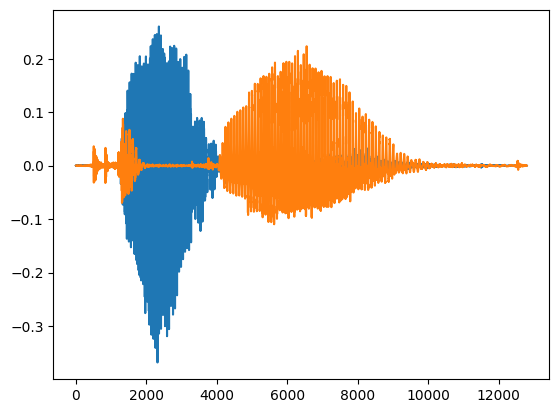

In [77]:
TRAIN_FILE = os.path.join('/content','drive','MyDrive','audio-data','Train','C03n_0.wav')
TEST_FILE = os.path.join('/content','drive','MyDrive','audio-data','Test','C04n_2.wav')

wave = load_wav_16k_mono(TRAIN_FILE)
nwave = load_wav_16k_mono(TEST_FILE)
plt.plot(wave)
plt.plot(nwave)
plt.show()

Check a sample of audio

In [78]:
TRAIN = os.path.join('/content','drive','MyDrive','audio-data', 'Train')
TEST = os.path.join('/content','drive','MyDrive','audio-data', 'Test')

Read all audio files and sort

In [79]:
train = tf.data.Dataset.list_files(TRAIN+'/*.wav')
train = sorted(list(train.as_numpy_iterator()))
train = tf.data.Dataset.from_tensor_slices(train)
test = tf.data.Dataset.list_files(TEST+'/*.wav')
test = sorted(list(test.as_numpy_iterator()))
test = tf.data.Dataset.from_tensor_slices(test)

Add Labels

In [80]:
iterations = 0
i = 0
train_label = []
while iterations!=len(train):
    iterations +=1
    train_label.append(i)
    i += 1
    if i == 10 :
        i = 0
train_label=keras.utils.to_categorical(train_label,num_classes)
trainings = tf.data.Dataset.zip((train, tf.data.Dataset.from_tensor_slices(train_label)))
#---------------------------------------------------------------#
iterations = 0
i = 0
test_label=[]
while iterations!=len(test):
    iterations +=1
    test_label.append(i)
    i += 1
    if i == 10 :
        i = 0
test_label=keras.utils.to_categorical(test_label,num_classes)
testings = tf.data.Dataset.zip((test, tf.data.Dataset.from_tensor_slices(test_label)))

Build Preprocessing Function to get spectogram

In [81]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    #wav = wav[:48000]
    #zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    #wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

Draw examples of spectogram

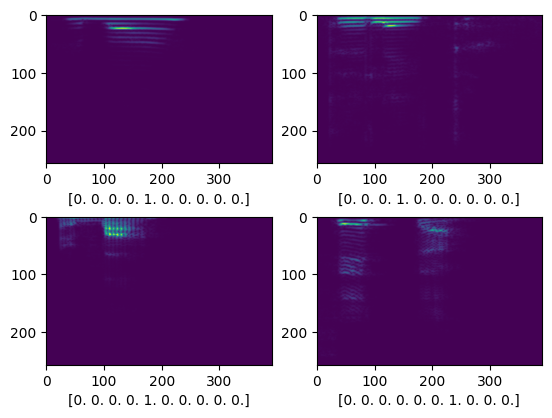

In [82]:
for i in range(4):
    filepath, label = trainings.shuffle(buffer_size=10000).as_numpy_iterator().next()
    spectrogram, label = preprocess(filepath, label)
    plt.subplot(2,2,i+1)
    plt.imshow(tf.transpose(spectrogram)[0])
    plt.xlabel(label)
plt.show()

Convert all to Spectogram

In [83]:
# train data
x_train = trainings.map(preprocess)
x_train = x_train.cache()
x_train = x_train.shuffle(buffer_size=1000)
x_train = x_train.batch(16) # 16 at a time
x_train = x_train.prefetch(8)
# test data
x_test = testings.map(preprocess)
x_test = x_test.cache()
x_test = x_test.shuffle(buffer_size=1000)
x_test = x_test.batch(16) # 16 at a time
x_test = x_test.prefetch(8)

In [84]:
# test one batch
samples, labels = x_train.as_numpy_iterator().next()
print(samples.shape)
print('\n',labels)

(16, 391, 257, 1)

 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


Design the CNN architecture

the 1st model

In [85]:
model1 = Sequential()

# Convolutional layer 1
model1.add(Conv2D(6, (5, 5), activation='relu', input_shape=(391, 257, 1), padding='valid'))

# Average pooling layer 1
model1.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Convolutional layer 2
model1.add(Conv2D(16, (5, 5), activation='relu', padding='valid'))

# Average pooling layer 2
model1.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Flatten layer
model1.add(Flatten())

# Fully connected layer 1
model1.add(Dense(120, activation='relu'))

# Fully connected layer 2
model1.add(Dense(84, activation='relu'))

# Output layer
model1.add(Dense(10, activation='softmax'))
model1.summary() 

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 387, 253, 6)       156       
                                                                 
 average_pooling2d_24 (Avera  (None, 193, 126, 6)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_25 (Conv2D)          (None, 189, 122, 16)      2416      
                                                                 
 average_pooling2d_25 (Avera  (None, 94, 61, 16)       0         
 gePooling2D)                                                    
                                                                 
 flatten_12 (Flatten)        (None, 91744)             0         
                                                                 
 dense_36 (Dense)            (None, 120)             

In [86]:
#Early Stopping to avoid fitting issues
early_stopping = EarlyStopping(monitor='accuracy', patience=5)

model1.compile(loss = keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

# Train the model
tic=time.time()
model1.fit(x_train, epochs=80, callbacks=[early_stopping])
toc=time.time()
training_time=toc-tic

Epoch 1/80
75/75 [==============================] - 18s 27ms/step - loss: 1.3095 - accuracy: 0.6408
Epoch 2/80
75/75 [==============================] - 2s 23ms/step - loss: 0.4219 - accuracy: 0.8983
Epoch 3/80
75/75 [==============================] - 2s 21ms/step - loss: 0.1560 - accuracy: 0.9658
Epoch 4/80
75/75 [==============================] - 2s 21ms/step - loss: 0.1012 - accuracy: 0.9792
Epoch 5/80
75/75 [==============================] - 1s 18ms/step - loss: 0.0735 - accuracy: 0.9850
Epoch 6/80
75/75 [==============================] - 1s 18ms/step - loss: 0.1282 - accuracy: 0.9808
Epoch 7/80
75/75 [==============================] - 1s 18ms/step - loss: 0.1137 - accuracy: 0.9792
Epoch 8/80
75/75 [==============================] - 1s 16ms/step - loss: 0.0534 - accuracy: 0.9950
Epoch 9/80
75/75 [==============================] - 1s 16ms/step - loss: 0.0187 - accuracy: 0.9967
Epoch 10/80
75/75 [==============================] - 1s 16ms/step - loss: 0.0024 - accuracy: 1.0000
Epoch 11

In [87]:
# Evaluate the model on the test data
tic=time.time()
test_loss, test_acc = model1.evaluate(x_test)
toc=time.time()
test_time=toc-tic


print("----- #1 - orignal model-----\n")
print("Training Time = {} s".format(np.round(training_time, 1)))
print("Testing Time = {} ms".format(np.round(test_time*1000, 1)))
print('Test Accuracy = {:.2f} %:'.format(np.round(test_acc, 3)*100))

19/19 [==============================] - 4s 9ms/step - loss: 2.2276 - accuracy: 0.8567
----- #1 - orignal model-----

Training Time = 38.5 s
Testing Time = 3582.1 ms
Test Accuracy = 85.70 %:


the 2nd model

In [88]:

model2 = Sequential()

# Convolutional layer 1
model2.add(Conv2D(6, (5, 5), activation='relu', input_shape=(391, 257, 1), padding='valid'))

#dropout regularization
model2.add(Dropout(0.2))

# Average pooling layer 1
model2.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Convolutional layer 2
model2.add(Conv2D(16, (5, 5), activation='relu', padding='valid'))

model2.add(Dropout(0.2))

# Average pooling layer 2
model2.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Flatten layer
model2.add(Flatten())

# Fully connected layer 1
model2.add(Dense(120, activation='relu'))
model2.add(Dropout(0.2))

# Fully connected layer 2
model2.add(Dense(84, activation='relu'))
model2.add(Dropout(0.2))

# Output layer
model2.add(Dense(10, activation='softmax'))

model2.summary() 


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 387, 253, 6)       156       
                                                                 
 dropout_12 (Dropout)        (None, 387, 253, 6)       0         
                                                                 
 average_pooling2d_26 (Avera  (None, 193, 126, 6)      0         
 gePooling2D)                                                    
                                                                 
 conv2d_27 (Conv2D)          (None, 189, 122, 16)      2416      
                                                                 
 dropout_13 (Dropout)        (None, 189, 122, 16)      0         
                                                                 
 average_pooling2d_27 (Avera  (None, 94, 61, 16)       0         
 gePooling2D)                                        

In [89]:
#Early Stopping to avoid fitting issues
early_stopping = EarlyStopping(monitor='accuracy', patience=3)

model2.compile(loss= keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

# Train the model
tic=time.time()
model2.fit(x_train, epochs=80, batch_size=32, callbacks=[early_stopping])
toc=time.time()
training_time=toc-tic

Epoch 1/80
75/75 [==============================] - 4s 23ms/step - loss: 1.6791 - accuracy: 0.4958
Epoch 2/80
75/75 [==============================] - 2s 21ms/step - loss: 0.7131 - accuracy: 0.7817
Epoch 3/80
75/75 [==============================] - 2s 22ms/step - loss: 0.5013 - accuracy: 0.8533
Epoch 4/80
75/75 [==============================] - 2s 21ms/step - loss: 0.3383 - accuracy: 0.9192
Epoch 5/80
75/75 [==============================] - 2s 23ms/step - loss: 0.2278 - accuracy: 0.9350
Epoch 6/80
75/75 [==============================] - 2s 23ms/step - loss: 0.2231 - accuracy: 0.9408
Epoch 7/80
75/75 [==============================] - 2s 21ms/step - loss: 0.1004 - accuracy: 0.9742
Epoch 8/80
75/75 [==============================] - 2s 21ms/step - loss: 0.0944 - accuracy: 0.9733
Epoch 9/80
75/75 [==============================] - 2s 21ms/step - loss: 0.1767 - accuracy: 0.9600
Epoch 10/80
75/75 [==============================] - 2s 21ms/step - loss: 0.0773 - accuracy: 0.9733


In [90]:
# Evaluate the model on the test data
tic=time.time()
test_loss, test_acc = model2.evaluate(x_test)
toc=time.time()
test_time=toc-tic


print("---- #2 the 2nd model-----\n")
print("Training Time = {} s".format(np.round(training_time, 1)))
print("Testing Time = {} ms".format(np.round(test_time*1000, 1)))
print('Test Accuracy = {:.2f} %:'.format(np.round(test_acc, 3)*100))


19/19 [==============================] - 0s 7ms/step - loss: 0.7661 - accuracy: 0.8633
---- #2 the 2nd model-----

Training Time = 20.2 s
Testing Time = 281.0 ms
Test Accuracy = 86.30 %:


the 3rd model

In [91]:
model3 = Sequential()

# Convolutional layer 1
model3.add(Conv2D(12, (5, 5), activation='relu', input_shape=(391, 257, 1), padding='same'))

# Average pooling layer 1
model3.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Convolutional layer 2
model3.add(Conv2D(32, (5, 5), activation='relu', padding='same'))

# Average pooling layer 2
model3.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Flatten layer
model3.add(Flatten())

# Fully connected layer 1
model3.add(Dense(120, activation='relu'))

# Fully connected layer 2
model3.add(Dense(84, activation='relu'))

# Output layer
model3.add(Dense(10, activation='softmax'))


model3.summary() 


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 391, 257, 12)      312       
                                                                 
 average_pooling2d_28 (Avera  (None, 195, 128, 12)     0         
 gePooling2D)                                                    
                                                                 
 conv2d_29 (Conv2D)          (None, 195, 128, 32)      9632      
                                                                 
 average_pooling2d_29 (Avera  (None, 97, 64, 32)       0         
 gePooling2D)                                                    
                                                                 
 flatten_14 (Flatten)        (None, 198656)            0         
                                                                 
 dense_42 (Dense)            (None, 120)             

In [92]:

#Early Stopping to avoid fitting issues
early_stopping = EarlyStopping(monitor='accuracy', patience=5)

model3.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])


# Train the model
tic=time.time()
model3.fit(x_train, epochs=80, batch_size=32, callbacks=[early_stopping])
toc=time.time()
training_time=toc-tic




Epoch 1/80
75/75 [==============================] - 4s 28ms/step - loss: 1.3406 - accuracy: 0.6283
Epoch 2/80
75/75 [==============================] - 2s 25ms/step - loss: 0.2879 - accuracy: 0.9225
Epoch 3/80
75/75 [==============================] - 2s 24ms/step - loss: 0.2405 - accuracy: 0.9417
Epoch 4/80
75/75 [==============================] - 2s 24ms/step - loss: 0.1124 - accuracy: 0.9717
Epoch 5/80
75/75 [==============================] - 2s 24ms/step - loss: 0.1616 - accuracy: 0.9700
Epoch 6/80
75/75 [==============================] - 2s 25ms/step - loss: 0.0184 - accuracy: 0.9967
Epoch 7/80
75/75 [==============================] - 2s 26ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 8/80
75/75 [==============================] - 2s 30ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 9/80
75/75 [==============================] - 2s 28ms/step - loss: 9.5883e-04 - accuracy: 1.0000
Epoch 10/80
75/75 [==============================] - 2s 24ms/step - loss: 6.4324e-04 - accuracy: 1.0000
E

In [93]:
# Evaluate the model on the test data
tic=time.time()
test_loss, test_acc = model3.evaluate(x_test)
toc=time.time()
test_time=toc-tic


print("----- #3 - the 3rd model-----\n")
print("Training Time = {} s".format(np.round(training_time, 1)))
print("Testing Time = {} ms".format(np.round(test_time*1000, 1)))
print('Test Accuracy = {:.2f} %:'.format(np.round(test_acc, 3)*100))

19/19 [==============================] - 0s 8ms/step - loss: 1.0015 - accuracy: 0.9100
----- #3 - the 3rd model-----

Training Time = 27.5 s
Testing Time = 439.6 ms
Test Accuracy = 91.00 %:


the 4th model

In [94]:

model4 = Sequential()

# Convolutional layer 1
model4.add(Conv2D(12, (5, 5), activation='tanh', input_shape=(391, 257, 1), padding='valid'))

# Average pooling layer 1
model4.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Convolutional layer 2
model4.add(Conv2D(32, (5, 5), activation='tanh', padding='valid'))

# Average pooling layer 2
model4.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

# Flatten layer
model4.add(Flatten())

# Fully connected layer 1
model4.add(Dense(120, activation='tanh'))

# Fully connected layer 2
model4.add(Dense(84, activation='tanh'))

# Output layer
model4.add(Dense(10, activation='softmax'))

model4.summary() 



Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 387, 253, 12)      312       
                                                                 
 average_pooling2d_30 (Avera  (None, 193, 126, 12)     0         
 gePooling2D)                                                    
                                                                 
 conv2d_31 (Conv2D)          (None, 189, 122, 32)      9632      
                                                                 
 average_pooling2d_31 (Avera  (None, 94, 61, 32)       0         
 gePooling2D)                                                    
                                                                 
 flatten_15 (Flatten)        (None, 183488)            0         
                                                                 
 dense_45 (Dense)            (None, 120)             

In [95]:
early_stopping = EarlyStopping(monitor='accuracy', patience=5)

model4.compile(loss = keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

# Train the model
tic=time.time()
model4.fit(x_train, epochs=80, batch_size=32, callbacks=[early_stopping])
toc=time.time()
training_time=toc-tic


Epoch 1/80
75/75 [==============================] - 5s 27ms/step - loss: 1.2450 - accuracy: 0.6425
Epoch 2/80
75/75 [==============================] - 2s 26ms/step - loss: 0.2714 - accuracy: 0.9442
Epoch 3/80
75/75 [==============================] - 2s 26ms/step - loss: 0.0994 - accuracy: 0.9850
Epoch 4/80
75/75 [==============================] - 2s 26ms/step - loss: 0.0397 - accuracy: 0.9983
Epoch 5/80
75/75 [==============================] - 2s 26ms/step - loss: 0.0149 - accuracy: 1.0000
Epoch 6/80
75/75 [==============================] - 2s 27ms/step - loss: 0.0085 - accuracy: 1.0000
Epoch 7/80
75/75 [==============================] - 2s 28ms/step - loss: 0.0063 - accuracy: 1.0000
Epoch 8/80
75/75 [==============================] - 2s 26ms/step - loss: 0.0050 - accuracy: 1.0000
Epoch 9/80
75/75 [==============================] - 2s 26ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 10/80
75/75 [==============================] - 2s 26ms/step - loss: 0.0035 - accuracy: 1.0000


In [96]:

# Evaluate the model on the test data
tic=time.time()
test_loss, test_acc = model4.evaluate(x_test)
toc=time.time()
test_time=toc-tic

print("----- #4 - the 4th model -----\n")
print("Training Time = {} s".format(np.round(training_time, 1)))
print("Testing Time = {} ms".format(np.round(test_time*1000, 1)))
print('Test Accuracy = {:.2f} %:'.format(np.round(test_acc, 3)*100))

19/19 [==============================] - 0s 11ms/step - loss: 0.3012 - accuracy: 0.9067
----- #4 - the 4th model -----

Training Time = 23.6 s
Testing Time = 440.5 ms
Test Accuracy = 90.70 %:
